# Wzbogacenie cech użytkowników

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from node2vec import Node2Vec
from gensim.models import Word2Vec
from pathlib import Path

import pandas as pd
import numpy as np

import seaborn as sns
from sklearn.decomposition import PCA
from umap import UMAP

import networkx as nx
import matplotlib.pyplot as plt

from src.evaluate_nodes import evaluate_node_classification

In [3]:
EMBBEDDINGS_PATH = Path("embbeddings")
DATA_PATH = Path("data")
IMAGES_PATH = Path("images")

RANDOM_STATE = 345

In [34]:
user_info_df = pd.read_csv(DATA_PATH / "labels_undirected.tsv", sep=" ").sort_values(by="user_id")
user_info_df

,user_id,department_id
0,0,1
1,1,1
2,2,19
3,3,19
4,4,19
...,...,...
971,1000,4
972,1001,19
973,1002,1
974,1003,6


## Tworzenie nowych reprezentacji

In [62]:
G = nx.read_gpickle(DATA_PATH / 'network.gpickle')

In [63]:
for v, data in G.nodes(data=True):
    data.pop("department_id")

In [64]:
dimensions = 128

In [65]:
node2vec = Node2Vec(
    G,
    dimensions=dimensions,
    walk_length=80, # numbers of nodes to walk
    num_walks=200, # walks per node
    workers=4,
    p=1,
    q=1
)
model = node2vec.fit(window=10, min_count=1, batch_words=4) 

Computing transition probabilities:   0%|          | 0/976 [00:00<?, ?it/s]

Generating walks (CPU: 3): 100%|██████████| 50/50 [01:17<00:00,  1.55s/it]


In [66]:
model.wv.save_word2vec_format(str(EMBBEDDINGS_PATH / f"embbeddings_{dimensions}.graphvectors"))
model.save(str(EMBBEDDINGS_PATH / f"graph_{dimensions}.model"))

## Wczytanie przygotowanych reprezentacji

In [74]:
dimensions = 64

In [75]:
model = Word2Vec.load(str(EMBBEDDINGS_PATH / f"graph_{dimensions}.model"))

In [35]:
model.wv[1]  # load embbedding

array([-0.1046075 , -0.00124475,  0.03384646, -0.06434071,  0.01214156,
       -0.02696043, -0.2603559 ,  0.10571606,  0.23223944, -0.14869714,
        0.20074569, -0.38078657,  0.03111846,  0.2691448 , -0.03588762,
       -0.22370036,  0.14772867,  0.0918    ,  0.00749237,  0.17559868,
        0.00929007, -0.12625562,  0.32112312, -0.12417665,  0.26879156,
        0.11668137, -0.02292748,  0.1233278 ,  0.21270768,  0.15430963,
       -0.0520625 ,  0.05928319,  0.21314107,  0.00132327,  0.19387983,
       -0.26892295,  0.09538969, -0.01297348, -0.21791577,  0.02982105,
       -0.01767905, -0.19644202,  0.05699281,  0.02673681, -0.03312445,
        0.0595552 , -0.01280661,  0.21948494,  0.044571  ,  0.255863  ,
       -0.18976536,  0.10613707,  0.11146925,  0.33196163,  0.06432861,
       -0.04550886,  0.02371467, -0.15921664, -0.31955835, -0.21145996,
        0.17849065, -0.12338667,  0.13385688, -0.08238632], dtype=float32)

## Analiza wygenerowanych embbedingów

In [56]:
def concat_embbeddings(model: Word2Vec):
    embbedings = []
    for i in range(len(model.wv.key_to_index)):
        result = model.wv[i]
        embbedings.append(result.reshape((1, result.shape[0])))
    return np.concatenate(embbedings, axis=0)

### Wektory o rozmiarze 64

In [76]:
model = Word2Vec.load(str(EMBBEDDINGS_PATH / "graph_64.model"))

In [77]:
full_embbedings = concat_embbeddings(model)
full_embbedings.shape

(976, 64)

In [78]:
colors = [user_info_df[user_info_df["user_id"] == int(id_)]["department_id"].iloc[0] for id_ in model.wv.key_to_index.keys()]
len(colors)

976

In [79]:
z_PCA = PCA(n_components=2).fit_transform(full_embbedings)
z_UMAP = UMAP(n_components=2).fit_transform(full_embbedings)

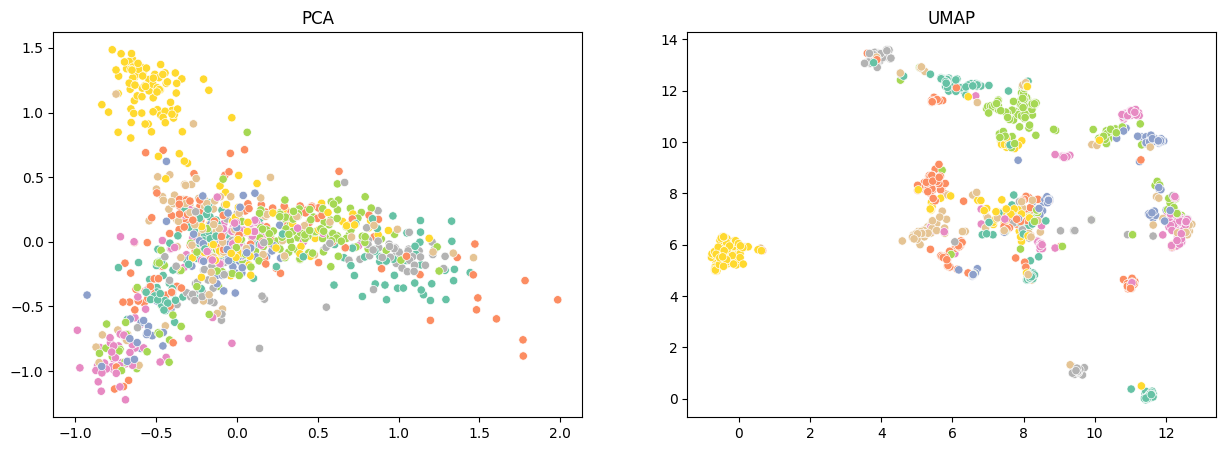

In [80]:
fig, axs = plt.subplots(ncols=2, figsize=(15, 5))
sns.scatterplot(x=z_PCA[:, 0], y=z_PCA[:, 1], hue=colors, palette="Set2", ax=axs[0])
axs[0].set(title="PCA")
axs[0].get_legend().remove()
sns.scatterplot(x=z_UMAP[:, 0], y=z_UMAP[:, 1], hue=colors, palette="Set2", ax=axs[1])
axs[1].set(title="UMAP")
axs[1].get_legend().remove()
fig.savefig(IMAGES_PATH / "basic_representation.png")

In [81]:
y_labels = colors
result_64 = evaluate_node_classification(y_labels, full_embbedings, random_state=RANDOM_STATE)
result_64

{'train_auc': 1.0, 'test_auc': 0.9667268893358614}

### Wektory o rozmiarze 128

In [85]:
model = Word2Vec.load(str(EMBBEDDINGS_PATH / "graph_128.model"))
full_embbedings = concat_embbeddings(model)
full_embbedings.shape

(976, 128)

In [86]:
colors = [user_info_df[user_info_df["user_id"] == int(id_)]["department_id"].iloc[0] for id_ in model.wv.key_to_index.keys()]
len(colors)

976

In [87]:
z_PCA = PCA(n_components=2).fit_transform(full_embbedings)
z_UMAP = UMAP(n_components=2).fit_transform(full_embbedings)

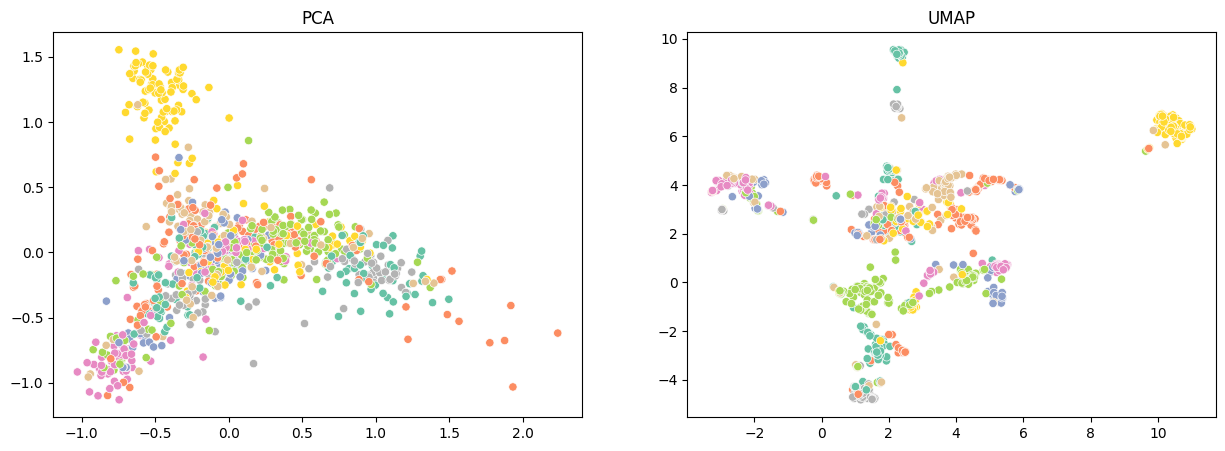

In [88]:
fig, axs = plt.subplots(ncols=2, figsize=(15, 5))
sns.scatterplot(x=z_PCA[:, 0], y=z_PCA[:, 1], hue=colors, palette="Set2", ax=axs[0])
axs[0].set(title="PCA")
axs[0].get_legend().remove()
sns.scatterplot(x=z_UMAP[:, 0], y=z_UMAP[:, 1], hue=colors, palette="Set2", ax=axs[1])
axs[1].set(title="UMAP")
axs[1].get_legend().remove()
fig.savefig(IMAGES_PATH / "basic_representation.png")

In [89]:
y_labels = colors
result_128 = evaluate_node_classification(y_labels, full_embbedings, random_state=RANDOM_STATE)
result_128

{'train_auc': 1.0, 'test_auc': 0.9688636291636552}

## Zapisanie wygenerowanych embbeddingów

In [82]:
def save_embbeddings_info(df: pd.DataFrame, index_map: dict):
    values = []
    for id_ in list(df.user_id):
        values.append(index_map[str(id_)])
    df["embbedding_id"] = values
    return df

In [83]:
user_info_df = save_embbeddings_info(user_info_df, model.wv.key_to_index)
user_info_df

,user_id,department_id,embbedding_id
0,0,1,274
1,1,1,214
2,2,19,62
3,3,19,121
4,4,19,63
...,...,...,...
971,1000,4,746
972,1001,19,670
973,1002,1,908
974,1003,6,912


In [84]:
user_info_df.to_csv(DATA_PATH / "train_data_64.tsv", sep=" ", index=False)